# K-means Case Study

-----

While the Iris data enabled a simple introduction to the k-means algorithm and cluster finding in general, most data sets will contain more features. As a result, we now switch to a real world data with more features. Specifically, in this notebook we will apply the k-means algorithm to the credit card dataset which has 5 features. We will apply k-means on this dataset to develop a customer segmentation for marketing strategy.

-----


## Table of Contents

[Credit Card Data](#Credit-Card-Data)

[K-means](#K-means)
- [Elbow Method](#Elbow-Method)
- [K-means Clustering](#K-means-Clustering)
- [Analyze Clustering Result](#Analyze-Clustering-Result)
- [Visualize Credit Card Dataset](#Visualize-Credit-Card-Dataset)
- [K-means: Performance](#K-means:-Performance)

-----

Before proceeding with the rest of this notebook, we first have our standard notebook setup code.

-----

In [1]:
# Set up Notebook

%matplotlib inline

# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# We do this to ignore several specific Pandas warnings
import warnings
warnings.filterwarnings("ignore")

# Set global figure properties
import matplotlib as mpl
mpl.rcParams.update({'axes.titlesize' : 20,
                     'axes.labelsize' : 18,
                     'legend.fontsize': 16})

# Set default Seaborn plotting style
sns.set_style('white')

-----
[[Back to TOC]](#Table-of-Contents)


## Credit Card Data

The credit card dataset summarizes the usage behavior of 8636 active credit card holders during the last 6 months. This dataset is created for this course from a dataset with a lot more features. You may find the original credit card dataset on [Kaggle][ccd].

Following is the Data Dictionary for Credit Card dataset :

- TOTAL_PURCHASES : Amount of total purchases made from account 
- PRC_CASH_ADVANCE : Percent of total purchases that is cash in advance given by the user. Cash in advance purchases are typically on-line purchases.
- CREDIT_LIMIT : Limit of Credit Card for user 
- MINIMUM_PAYMENTS : Minimum amount of payments made by user 
- PRCFULLPAYMENT : Percent of full payment paid by user 

The first code cell below loads the credit card data into the notebook. The next code cell display the basic information of the dataset. The thrid code cell displays the basic statistics of the dataset. Please note that data understanding and data preparation are most import steps in data analytics. The two steps normally account for about 80% of total time and effort by analysts. But in this notebook we will focus on clustering(which is the modeling step in the CRISP-DM framework). We assume the data is already cleaned and we won't spend too much time on data understanding other than displaying basic statistics.

-----
[ccd]:https://www.kaggle.com/arjunbhasin2013/ccdata

In [2]:
df_cc = pd.read_csv('data/Credit_Card.csv')
df_cc.head()

,TOTAL_PURCHASES,PRC_CASH_ADVANCE,CREDIT_LIMIT,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
0,95.410000,0.000000,1000.0,139.509787,0.000000
1,6442.955483,0.999998,7000.0,1072.340217,0.222222
2,773.180000,0.000000,7500.0,627.284787,0.000000
3,16.010000,0.000000,1200.0,244.791237,0.000000
4,1333.290000,0.000000,1800.0,2407.246035,0.000000


In [3]:
df_cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 5 columns):
TOTAL_PURCHASES     8636 non-null float64
PRC_CASH_ADVANCE    8636 non-null float64
CREDIT_LIMIT        8636 non-null float64
MINIMUM_PAYMENTS    8636 non-null float64
PRC_FULL_PAYMENT    8636 non-null float64
dtypes: float64(5)
memory usage: 337.5 KB


In [4]:
df_cc.describe()

,TOTAL_PURCHASES,PRC_CASH_ADVANCE,CREDIT_LIMIT,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT
count,8636.000000,8636.000000,8636.000000,8636.000000,8636.000000
mean,2019.619398,0.381541,4522.091030,864.304943,0.159304
std,2950.021139,0.442971,3659.240379,2372.566350,0.296271
min,0.010000,0.000000,50.000000,0.019163,0.000000
25%,379.667726,0.000000,1600.000000,169.163545,0.000000
50%,1095.557789,0.000000,3000.000000,312.452292,0.000000
75%,2556.502427,0.953255,6500.000000,825.496463,0.166667
max,49597.746886,1.000000,30000.000000,76406.207520,1.000000


---
[[Back to TOC]](#Table-of-Contents)

## K-means

Now the data is loaded, we first standardize the features in the next code cell. 

In [5]:
from sklearn.preprocessing import StandardScaler
x_cc = StandardScaler().fit_transform(df_cc)

---

### Elbow Method

To determine proper cluster number(k), we plot the elbow plot in the next code cell. As the plot shows, there is no clear elbow which normally indicate that there's no clear cut of clusters in the dataset. This is very common in real life data.

In this notebook, we will arbitrarily choose k=6 for the k-means model.

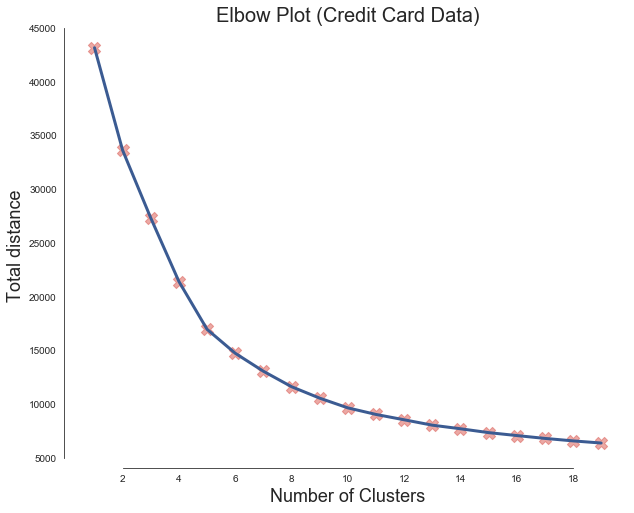

In [12]:
from sklearn.cluster import KMeans

# Search for best number of clusters, from one to ten
n_clusters = np.arange(1, 20)
distances = np.zeros(n_clusters.shape[0])

# Perform k-means clustering for different numbers of clusters
# Use the inertia (or sum of total distances between points
# and cluster centers) as the performance metric.
for idx, nc in enumerate(n_clusters):
    # We build our model for nc clusters
    model = KMeans(n_clusters=nc, n_init=10, random_state=23)
    model.fit(x_cc)
    distances[idx] = model.inertia_
# Plot elbow method
fig, ax = plt.subplots(figsize=(10, 8))

# Draw points and connect them
ax.scatter(n_clusters, distances, s=150, 
           c=sns.xkcd_rgb['pale red'], marker='X', alpha=0.5)
ax.plot(n_clusters, distances, lw=3, linestyle='-', 
        color=sns.xkcd_rgb['denim blue'])

# Define elbow at three clusters
elb = (n_clusters[2], distances[2])

# Decorate Plot
ax.set(title='Elbow Plot (Credit Card Data)', 
       xlabel='Number of Clusters', 
       ylabel='Total distance')
ax.set_xticks(range(2,20,2))
sns.despine(offset=5, trim=True)

---
### K-means Clustering

In the following code cells, we create the estimator by specifying six clusters, by indicating that twenty-five different runs should be performed, and by specifying a random state for reproducibility.

We then print out the count of each clusters. Clust 4 and 5 only has 56 and 69 data points which is too small to be meaningful.

In [7]:
# We build our model assuming three clusters
k_means = KMeans(n_clusters=6, n_init=25, random_state=23)

# We fit our data to assign classes
k_means.fit(x_cc)

# Obtain the predictions
y_pred = k_means.predict(x_cc)

In [8]:
from collections import Counter 
cnt =  Counter(np.sort(y_pred))

# Display some basic results of the clustering
print('KMeans Cluster membership.')
print(30*'-')
for itm in cnt:
    if itm < 0:
        print(f'Noise Cluster : {cnt[itm]:>4d} members')
    else:
        print(f'Cluster {itm}     : {cnt[itm]:>4d} members')

KMeans Cluster membership.
------------------------------
Cluster 0     : 3436 members
Cluster 1     : 2572 members
Cluster 2     : 1270 members
Cluster 3     : 1233 members
Cluster 4     :   56 members
Cluster 5     :   69 members


---

### Analyze Clustering Result

Next, we plot pairplot of the features and clusters to find out characteristics of each cluster. The pairplot indicates there's really no clear separations among clusters. But we can still draw some conclusions from the plot:
- cluster 0 has the most data points. Accounts in this cluster have low credit limit, are low on total purchase, don't make much on-line purchase.
- accounts in cluster 1 made most purchase on-line, this is indicated by the last column in the 2nd row. The accounts have low credit limit and low total purchase. Accounts in this cluster may belong to the younger generation.
- accounts in cluster 2 made more full payments than other that of other clusters. These accounts are _safe_ or _conservative_ users who are more likely to make full payment. 
- accounts in cluster 4, on the other hand, tend to make minimum payments.
- accounts in cluster 5 made most total purchases, their credit limit is on the high side. They didn't make minimum payment often.

We can then develop a marketing strategy based on this information. For example, we may push on-line sales information to accounts in cluster 1; or we may provide more promotions to safe users in cluster 2.

Again, this analysis is very primitive. There are a lot of in-depth analysis that need to be done to get more useful information. Many times, you will have to accept that fact that the data you have may not provide enough information for a meaningful clustering analysis.

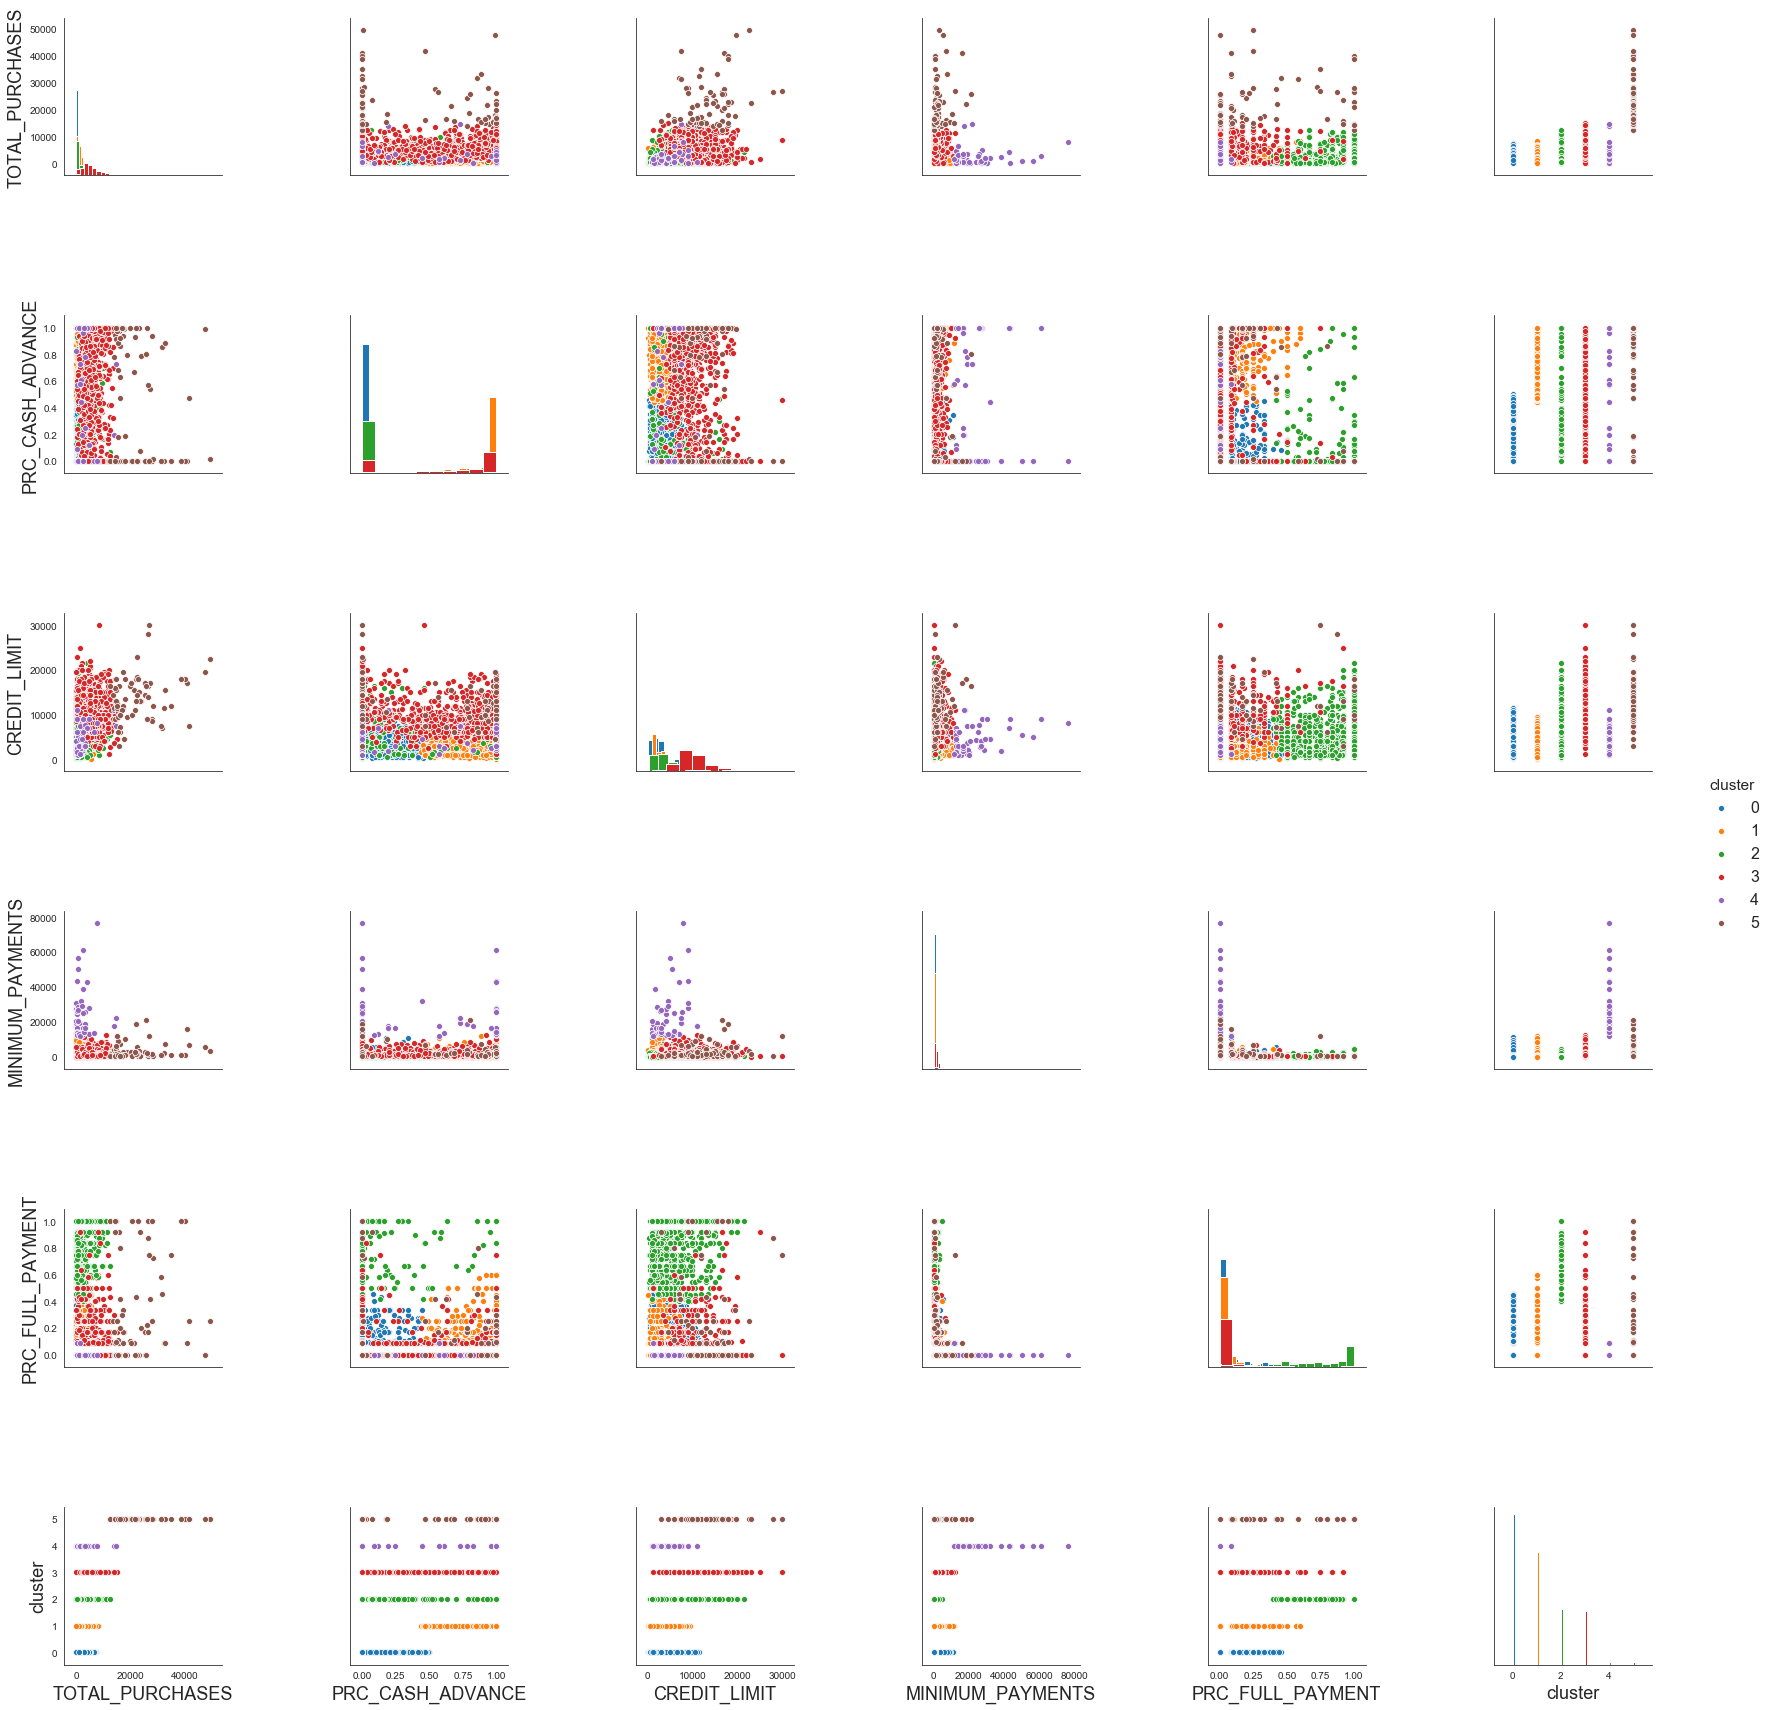

In [9]:
df_cc['cluster'] = y_pred
grid = sns.pairplot( df_cc, hue="cluster", diag_kind='hist')
grid.fig.set_size_inches(25,25)

---

### Visualize Credit Card Dataset

In the following code cell, we first use PCA to transform the credit card dataset to a two dimensional space, then plot the data points in the new two-dimensional space. We plot each cluster in different colors with their cluster center represented by **X**. This scatter plot is a common way to examine whether the dataset has clear separations between clusters.

From this plot we can see that there's really no clear clustering patterns.

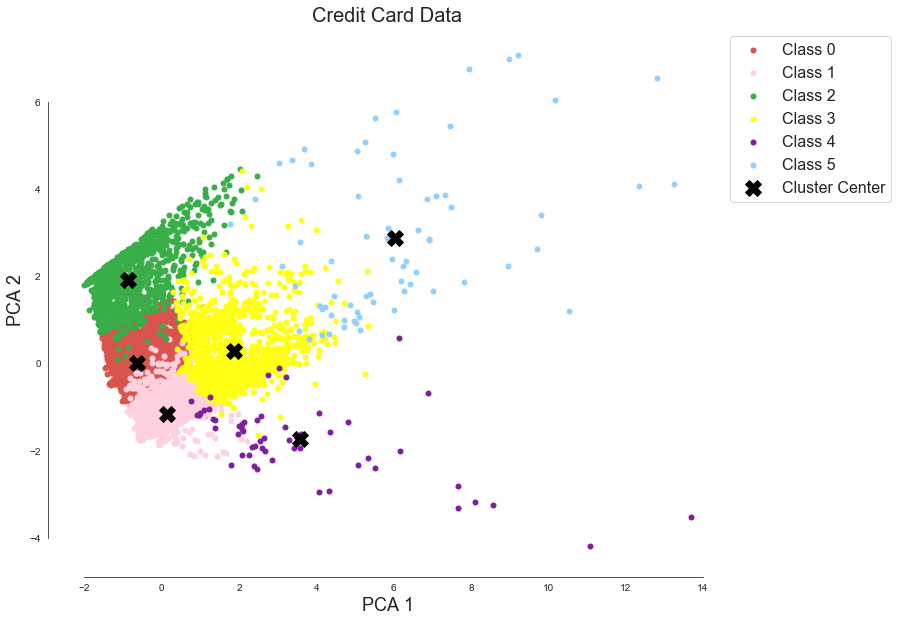

In [10]:
from sklearn.decomposition import PCA

# Principal Component Analysis
pca = PCA(n_components=2, random_state=23)

# Fit model to the data
xx_cc = pca.fit_transform(x_cc)

# append label to reduced dataset.
data = np.concatenate((xx_cc, y_pred.reshape(x_cc.shape[0], 1)), axis=1)

# Reduced features with real classes
cols = ['PCA1', 'PCA2', 'Class']

# Reduced Features with predicted classes
pc = pd.DataFrame(data, columns = cols)

cc = k_means.cluster_centers_
cc_pca = pca.transform(cc)

# Two sets of colors, can modify these to ensure colors match 
# between known and predicted clusters.
pclr = [sns.xkcd_rgb['pale red'], 
        sns.xkcd_rgb['light pink'],
        sns.xkcd_rgb['medium green'],
        sns.xkcd_rgb['yellow'],
        sns.xkcd_rgb['purple'],
        sns.xkcd_rgb['light blue']]

# Label data
plbls = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']


# Predicted Clusters

# Now make the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot each species separately
for idx in range(6):
    
    # Plot assignd cluster as small point
    tmp_pdf = pc[pc['Class'] == idx]
    ax.scatter(tmp_pdf['PCA1'], tmp_pdf['PCA2'], 
               color=pclr[idx], label=plbls[idx], alpha=1, s=25)

# Plot cluster centers
ax.scatter(cc_pca[:,0], cc_pca[:,1], 
           s=250, c='k', marker='X', 
           label='Cluster Center')

# Decorate Plot
ax.set(title='Credit Card Data', xlabel='PCA 1', ylabel='PCA 2')
ax.legend(bbox_to_anchor=(1.0, 1), loc=2)
sns.despine(offset=5, trim=True)

-----

### K-means: Performance

The following Code cell computes the Silhouette score for the credit card data. The score is low which is not a surprise. From the two-dimensional scatter plot of the credit card data set, we can see that there is no clear separations among clusters. This dataset is only a subset of original credit card dataset which has a lot more features. We could have got better clustering result with more features but it's not guaranteed.

----


In [11]:
from sklearn import metrics
ss = metrics.silhouette_score(x_cc, y_pred)
print (f'Silhouette Score:{ss:5.3f}')

Silhouette Score:0.415


-----

<font color='red' size = '5'> Student Exercise </font>

In the preceding cells, we used the k-means algorithm on the credit card dataset.  Now that you have run the notebook, go back and make the following changes to see how the results change.

1. Change the number of clusters (higher and lower) in the k-means clustering algorithm, how do the results change? 

-----

## Ancillary Information

The following links are to additional documentation that you might find helpful in learning this material. Reading these web-accessible documents is completely optional.

1. Performing [customer segmentation][csm] for more effective retail marketing in a blog article by Varda Tirosh at Optimove.

-----

[csm]: http://www.optimove.com/blog/customer-segmentation-for-more-effective-marketing


**&copy; 2019: Gies College of Business at the University of Illinois.**

This notebook is released under the [Creative Commons license CC BY-NC-SA 4.0][ll]. Any reproduction, adaptation, distribution, dissemination or making available of this notebook for commercial use is not allowed unless authorized in writing by the copyright holder.

[ll]: https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode 